In [1]:
# Εγκατάσταση των βιβλιοθηκών numpy (για αριθμητικούς υπολογισμούς), pandas (για επεξεργασία δεδομένων),
# matplotlib και seaborn (για οπτικοποίηση δεδομένων), scikit-learn (για machine learning) και torch (για deep learning)
# Οι βιβλιοθήκες είναι ήδη εγκατεστημένες στο περιβάλλον και δεν χρειάζεται να τις ξαναεγκαταστήσουμε.
# Αν κάποιος τρέξει το notebook σε νέο περιβάλλον, θα χρειαστεί να εκτελέσει την εξής εντολή για να εγκαταστήσει τις βιβλιοθήκες:
# !pip install numpy pandas matplotlib seaborn scikit-learn torch


In [ ]:
# Εισαγωγή των απαραίτητων βιβλιοθηκών

import os  # Χειρισμός αρχείων και φακέλων
import numpy as np  # Πίνακες και αριθμητικές πράξεις
import random  # Επιλογή τυχαίων εικόνων, ορισμός seed
from PIL import Image  # Ανάγνωση και επεξεργασία εικόνων
import matplotlib.pyplot as plt  # Οπτικοποίηση
import seaborn as sns  # Οπτικοποίηση (countplot, boxplot)
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Κανονικοποίηση, κωδικοποίηση ετικετών
from sklearn.feature_selection import VarianceThreshold  # Feature selection
from sklearn.model_selection import train_test_split  # Διαχωρισμός δεδομένων
import shutil  # Αντιγραφή αρχείων
import torch  # Seed και σταθερότητα για PyTorch 


In [ ]:
# Ορισμός του seed για αναπαραγωγιμότητα
seed = 42
random.seed(seed)  # Για τη βιβλιοθήκη random
np.random.seed(seed)  # Για τη βιβλιοθήκη NumPy

# Για PyTorch, αν το χρησιμοποιείς:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Σε πολλαπλές GPU αν υπάρχουν

# Ρυθμίσεις για αναπαραγωγιμότητα με GPU
torch.backends.cudnn.deterministic = True  # Αναγκάζει ντετερμινιστικές πράξεις
torch.backends.cudnn.benchmark = False  # Απενεργοποιεί το benchmarking για τα βελτιστοποιημένα μεγέθη μπλοκ

# Ελέγχουμε εάν το seed έχει ρυθμιστεί σωστά
print(f"Random seed set to {seed}")

Random seed set to 42


In [4]:
# Φορτώνουμε τις εικόνες από τις κατηγορίες "BreastMRI", "ChestCT", "CXR", "Hand" 
# και οπτικοποιούμε τις 5 πρώτες από κάθε κατηγορία για να ελέγξουμε την ποιότητα των δεδομένων και να επιβεβαιώσουμε την ορθότητα της ταξινόμησης. 
# Η οπτικοποίηση μας βοηθά να εντοπίσουμε τυχόν προβλήματα ή ασυμφωνίες στις εικόνες.

# Φάκελος με τις εικόνες
input_dir = './archive' 

# Οι κατηγορίες
my_categories = ['BreastMRI', 'ChestCT', 'CXR', 'Hand']

# Αποθήκευση εικόνων και ετικετών
images = []
labels = []

for category in my_categories:
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        print(f"Φορτώνεται κατηγορία: {category}")
        for filename in os.listdir(category_path):
            if filename.endswith(('.jpeg', '.png')):
                image_path = os.path.join(category_path, filename)
                try:
                    img = Image.open(image_path).convert('L').resize((64, 64))
                    images.append(np.array(img))
                    labels.append(category)
                except Exception as e:
                    print(f"Πρόβλημα με την εικόνα {image_path}: {e}")

# Μετατροπή σε NumPy πίνακες
X = np.array(images)
y = np.array(labels)

# Έλεγχος
print(f"Σύνολο εικόνων: {len(X)}")
print(f"Σχήμα πίνακα εικόνων: {X.shape}")
print(f"Κατηγορίες που φορτώθηκαν: {np.unique(y)}")

Φορτώνεται κατηγορία: BreastMRI
Φορτώνεται κατηγορία: ChestCT
Φορτώνεται κατηγορία: CXR
Φορτώνεται κατηγορία: Hand
Σύνολο εικόνων: 38953
Σχήμα πίνακα εικόνων: (38953, 64, 64)
Κατηγορίες που φορτώθηκαν: ['BreastMRI' 'CXR' 'ChestCT' 'Hand']


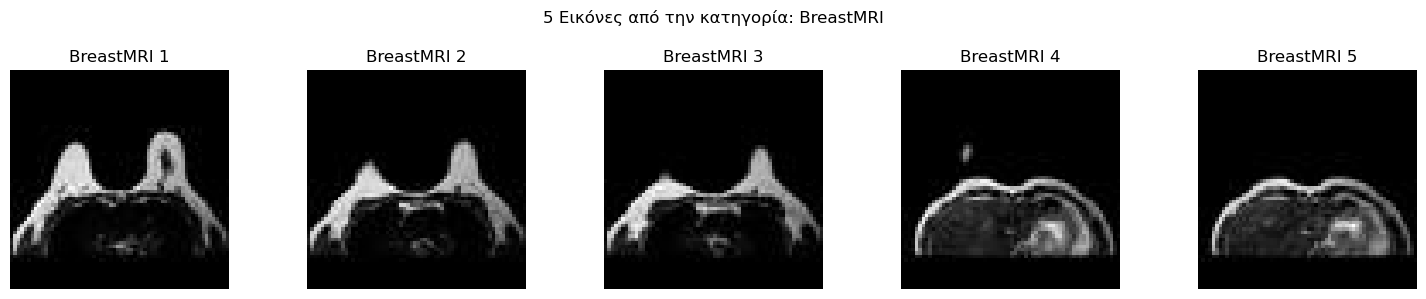

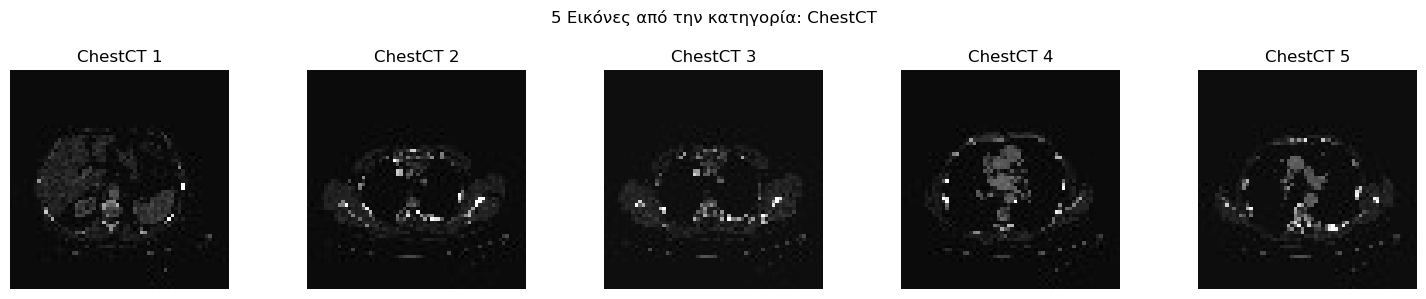

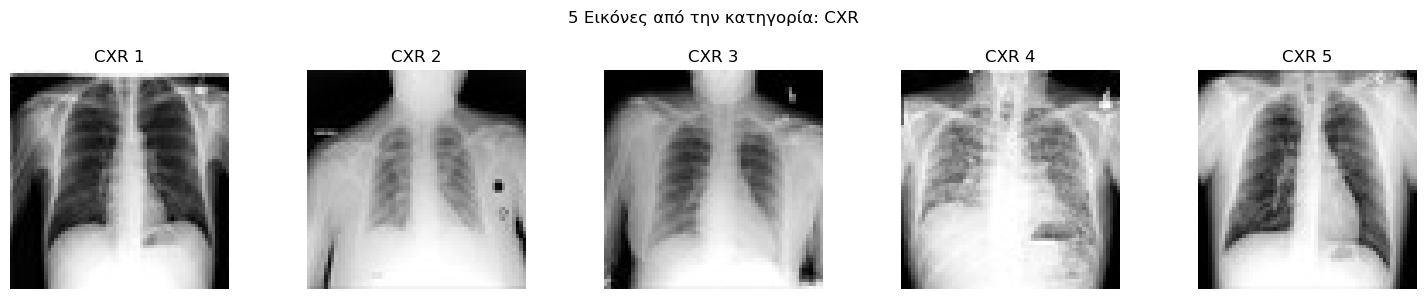

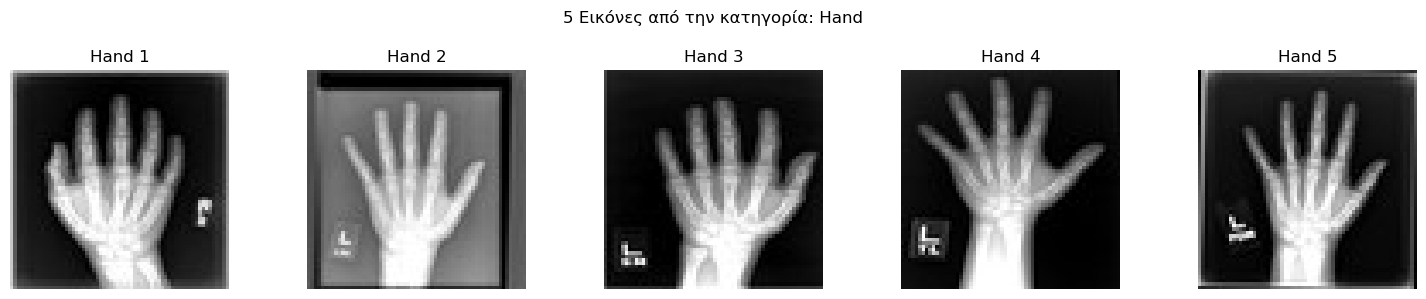

In [5]:
def plot_first_5_images_per_class(X, y, categories):
    for category in categories:
        idxs = [i for i, label in enumerate(y) if label == category][:5]
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(idxs):
            plt.subplot(1, 5, i + 1)
            plt.imshow(X[idx], cmap='gray')
            plt.title(f"{category} {i+1}")
            plt.axis('off')
        plt.suptitle(f"5 Εικόνες από την κατηγορία: {category}")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

plot_first_5_images_per_class(X, y, my_categories)

In [6]:
# Υπολογισμός των βασικών στατιστικών
mean_pixel_value = np.mean(X)
median_pixel_value = np.median(X)
std_pixel_value = np.std(X)
min_pixel_value = np.min(X)
max_pixel_value = np.max(X)

# Υπολογισμός του 25ου, 50ου και 75ου εκατοστημόριου
percentiles = np.percentile(X, [25, 50, 75])

print(f"Μέση τιμή pixel: {mean_pixel_value}")
print(f"Διάμεσος: {median_pixel_value}")
print(f"Τυπική απόκλιση: {std_pixel_value}")
print(f"Ελάχιστη τιμή: {min_pixel_value}")
print(f"Μέγιστη τιμή: {max_pixel_value}")
print(f"25ο, 50ο, 75ο εκατοστημόριο: {percentiles}")

Μέση τιμή pixel: 94.17698467970415
Διάμεσος: 123.0
Τυπική απόκλιση: 78.59970893654427
Ελάχιστη τιμή: 0
Μέγιστη τιμή: 255
25ο, 50ο, 75ο εκατοστημόριο: [  7. 123. 139.]


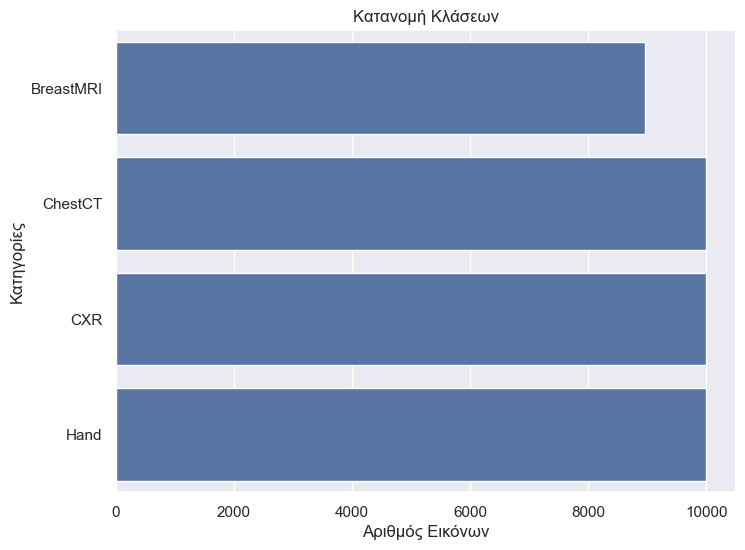

In [7]:
# Ανάλυση κατανομής των κατηγοριών
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(y=y)  # Χρησιμοποιούμε το y για τις ετικέτες
plt.title('Κατανομή Κλάσεων')
plt.xlabel('Αριθμός Εικόνων')
plt.ylabel('Κατηγορίες')
plt.show()

Αρχικά πραγματοποιήθηκε τυποποίηση των pixel τιμών μέσω της μεθόδου StandardScaler, προκειμένου να διασφαλιστεί ότι κάθε χαρακτηριστικό έχει μέση τιμή 0 και τυπική απόκλιση 1.

Ακολούθως, αναλύθηκαν οι κατανομές μέσω boxplots για κάθε κατηγορία. Παρά την τυποποίηση, διαπιστώθηκε η παρουσία ακραιών τιμών (outliers), οι οποίες εντοπίστηκαν με χρήση του κανόνα IQR (Q1 – 1.5IQR, Q3 + 1.5IQR).

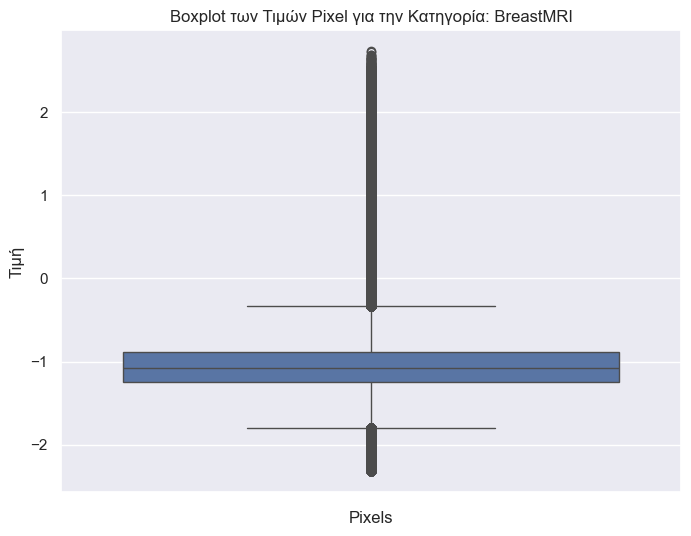

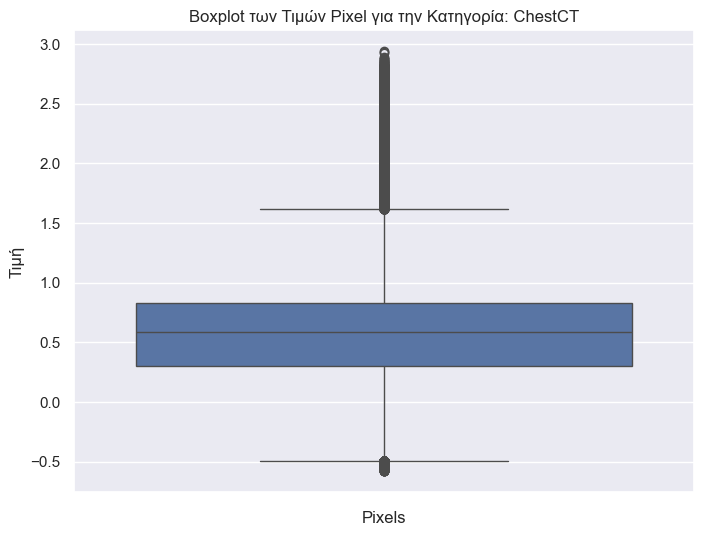

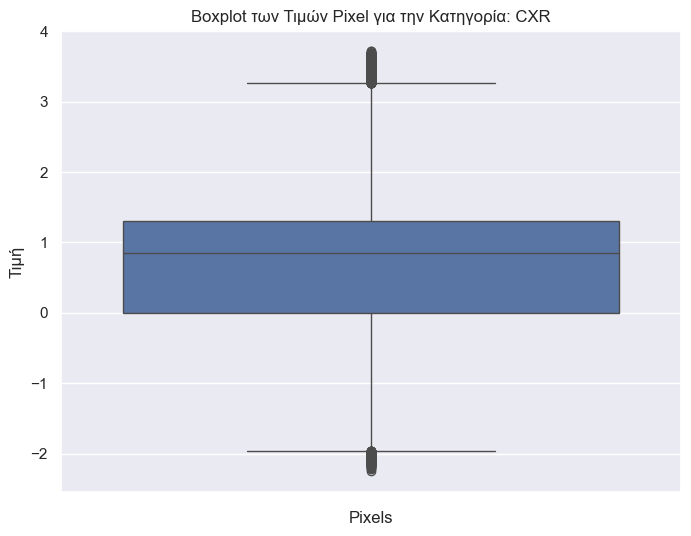

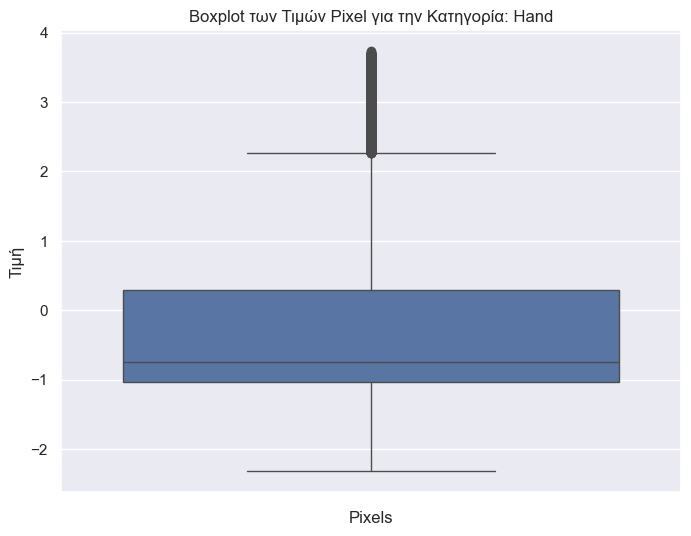

In [8]:
# Κανονικοποίηση/Τυποποίηση των εικόνων
X_reshaped = X.reshape(X.shape[0], -1)  # Αναδιάταξη των εικόνων σε επίπεδο (4096 χαρακτηριστικά ανά εικόνα)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_reshaped)  # Τυποποίηση

# Δημιουργία boxplot για κάθε κατηγορία
for category in my_categories:
    idxs = [i for i, label in enumerate(y) if label == category]

    # Λαμβάνουμε μόνο τα πρώτα 500 στοιχεία από κάθε κατηγορία (για να επιταχύνουμε την επεξεργασία)
    num_samples = min(500, len(idxs))  # Εξασφαλίζουμε ότι παίρνουμε τα δεδομένα μόνο αν υπάρχουν τουλάχιστον 500
    category_data = X_normalized[idxs[:num_samples]].reshape(-1)  # Αναδιάταξη σε επίπεδο

    # Δημιουργία boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=category_data)  # Δημιουργία boxplot για τα pixel της κατηγορίας
    plt.title(f'Boxplot των Τιμών Pixel για την Κατηγορία: {category}')
    plt.xlabel('Pixels')
    plt.ylabel('Τιμή')
    plt.show()

    # Αποθήκευση του boxplot ως εικόνα για μελλοντική χρήση
    plt.savefig(f'{category}_boxplot.png')
    plt.close()  # Κλείσιμο της εικόνας για να αποδεσμευτεί η μνήμη

Ο αριθμός των outliers είναι 7.750, όπως φαίνεται ακολούθως, κάτι το οποίο θεωρείται αναμενόμενο λόγω της φύσης των δεδομένων εικόνας. Οι εν λόγω τιμές δεν αφαιρέθηκαν καθώς θεωρούνται τμήμα της χρήσιμης πληροφορίας (π.χ. έντονα φωτεινές ή σκοτεινές περιοχές της εικόνας) και όχι σφάλματα μέτρησης. Επιπλέον, η χρήση robust scaling δεν κρίθηκε αναγκαία καθώς η StandardScaler απέδωσε ικανοποιητικά και τα μοντέλα είναι αρκετά ανθεκτικά σε τέτοια outliers. Πραγματοποιήθηκε επίσης έλεγχος για ελλείπουσες τιμές (NaN) και δεν εντοπίστηκε καμία.

In [9]:
# Μετατροπή του X (εικόνες) σε μονοδιάστατο πίνακα για να αναλύσουμε όλα τα δεδομένα
all_pixels = X_normalized.reshape(-1)  # Μετατροπή όλων των εικόνων σε μονοδιάστατο πίνακα

# Υπολογισμός των στατιστικών
Q1 = np.percentile(all_pixels, 25)
Q3 = np.percentile(all_pixels, 75)
median = np.median(all_pixels)
IQR = Q3 - Q1

# Υπολογισμός των ακραιών τιμών
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = all_pixels[(all_pixels < lower_bound) | (all_pixels > upper_bound)]

# Εκτύπωση των στατιστικών και των ακραιών τιμών
print(f"Στατιστικά για όλες τις εικόνες:")
print(f"  25ο Πεντημόριο (Q1): {Q1:.4f}")
print(f"  Διάμεσος (Median): {median:.4f}")
print(f"  75ο Πεντημόριο (Q3): {Q3:.4f}")
print(f"  Εύρος IQR: {IQR:.4f}")
print(f"  Κατώτατο όριο (Lower Bound): {lower_bound:.4f}")
print(f"  Ανώτατο όριο (Upper Bound): {upper_bound:.4f}")
print(f"  Συνολικός αριθμός ακραιών τιμών (Outliers): {len(outliers)}")
print(f"Ελάχιστη τιμή pixel: {all_pixels.min()}")
print(f"Μέγιστη τιμή pixel: {all_pixels.max()}")
print(f"  Πρώτες 10 ακραιές τιμές (Outliers): {outliers[:10]}")

missing_values = np.isnan(X_normalized)  # Για πίνακες numpy
print(f"Συνολικός αριθμός ελλειπουσών τιμών: {missing_values.sum()}")

# Αφαίρεση χαρακτηριστικών με διακύμανση μικρότερη από 0.01
selector = VarianceThreshold(threshold=0.01)
X_reduced_var = selector.fit_transform(X_normalized)

print(f"Αρχικός αριθμός χαρακτηριστικών: {X_normalized.shape[1]}")
print(f"Αριθμός χαρακτηριστικών μετά τη μείωση: {X_reduced_var.shape[1]}")

Στατιστικά για όλες τις εικόνες:
  25ο Πεντημόριο (Q1): -0.9763
  Διάμεσος (Median): 0.1027
  75ο Πεντημόριο (Q3): 0.8236
  Εύρος IQR: 1.7999
  Κατώτατο όριο (Lower Bound): -3.6761
  Ανώτατο όριο (Upper Bound): 3.5235
  Συνολικός αριθμός ακραιών τιμών (Outliers): 7750
Ελάχιστη τιμή pixel: -2.319106606967984
Μέγιστη τιμή pixel: 3.731646965612793
  Πρώτες 10 ακραιές τιμές (Outliers): [3.5705808  3.56406764 3.56211446 3.60300324 3.55152759 3.55725103
 3.53808025 3.62595531 3.59861131 3.57967407]
Συνολικός αριθμός ελλειπουσών τιμών: 0
Αρχικός αριθμός χαρακτηριστικών: 4096
Αριθμός χαρακτηριστικών μετά τη μείωση: 4096


Παρατηρούμε ότι μετά τη μείωση των χαρακτηριστικών με διακύμανση μικρότερη από 0.01, παρέμειναν 4096, οπότε μπορούμε να παραλείψουμε το συγκεκριμένο feature engineering, καθώς το dataset μας ήδη έχει 4096 χαρακτηριστικά, και μπορούμε να εφαρμόσουμε μείωση διαστάσεων χωρίς να προσθέσουμε επιπλέον χαρακτηριστικά.

In [10]:
# Ρυθμίσεις
src_dir, dest_dir = 'archive', 'archive_smaller'
my_categories = ['BreastMRI', 'ChestCT', 'CXR', 'Hand']
max_images_per_class = 1000

# Δημιουργία φακέλου προορισμού
os.makedirs(dest_dir, exist_ok=True)

# Αντιγραφή τυχαίων εικόνων
for category in my_categories:
    category_path = os.path.join(src_dir, category)
    dest_class_path = os.path.join(dest_dir, category)
    os.makedirs(dest_class_path, exist_ok=True)

    all_images = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_images = random.sample(all_images, min(max_images_per_class, len(all_images)))
    
    for img in selected_images:
        shutil.copy(os.path.join(category_path, img), dest_class_path)

# Φόρτωση και προεπεξεργασία
images, labels = [], []

for category in os.listdir(dest_dir):
    category_path = os.path.join(dest_dir, category)
    for file_name in os.listdir(category_path):
        if file_name.endswith(('.jpeg', '.png')):  # Έλεγχος για εικόνες
            try:
                img = Image.open(os.path.join(category_path, file_name)).resize((64, 64)).convert('L')
                images.append(np.array(img))
                labels.append(category)
            except Exception as e:
                print(f"Error loading {file_name}: {e}")

# Μετατροπή σε NumPy πίνακες και Label Encoding
images = np.array(images)
labels = np.array(labels)

# Κωδικοποίηση των ετικετών με LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Αποθήκευση της αντιστοίχισης κατηγοριών και αριθμών
category_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Έλεγχος
print(f"Loaded {len(images)} images.")
print(f"Image shape: {images[0].shape} ")
print(f"Labels: {np.unique(labels)}")


Loaded 4000 images.
Image shape: (64, 64) 
Labels: ['BreastMRI' 'CXR' 'ChestCT' 'Hand']


In [ ]:
# Διαχωρισμός σε Training και Test Sets πρώτα (απλά για να χωρίσεις τα δεδομένα)
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded, test_size=0.3, random_state=random_state, stratify=labels_encoded
)

# Αναδιάταξη και κανονικοποίηση στο training set
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_reshaped)

# Αναδιάταξη και κανονικοποίηση στο test set, με τον ίδιο scaler
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_normalized = scaler.transform(X_test_reshaped)  # Χρησιμοποιούμε το ίδιο fit από το training set

# Αποθήκευση των κανονικοποιημένων δεδομένων
np.savez('train_test_images_normalized_images.npz', 
         X_train=X_train_normalized, 
         X_test=X_test_normalized, 
         y_train=y_train, 
         y_test=y_test,
         class_names=my_categories)  # Αποθήκευση των ονομάτων των κατηγοριών

# Εκτύπωση του σχήματος των συνόλων εκπαίδευσης και δοκιμής
print(f"Σχήμα Συνόλου Εκπαίδευσης: {X_train_normalized.shape}, ετικέτες: {y_train.shape}")
print(f"Σχήμα Συνόλου Δοκιμής: {X_test_normalized.shape}, ετικέτες: {y_test.shape}")

Σχήμα X_normalized: (4000, 4096)
Σχήμα Συνόλου Εκπαίδευσης: (2800, 4096), ετικέτες: (2800,)
Σχήμα Συνόλου Δοκιμής: (1200, 4096), ετικέτες: (1200,)
